# Witam,
Na wstępie chciałbym powiedzieć, że największe problemy były po stronie fizycznej - mianowicie podczas pisania tego programu, mój komputer przegrzewał a następnie restertował się ponad 5 razy.

Napisałem w sumie wiele programów, z tego względu, że pierwszy miał score 0.78, więc wstyd mi było takie coś oddawać.

Więc zacząłem szukać i badać od najlepszego klasyfikatora, aż skończyłem importując z hugging face distillBERTA, a potem samego BERTA.

Jednak, to była walka z wiatrakami, ze względu na to, że **NIE DA SIĘ MIEĆ 100% ** ponieważ są tam tweety których tekst się powtarza, a label się zmienia
Więc raz te tweety są zczytywane tak a raz na odwrót. Screen poniżej
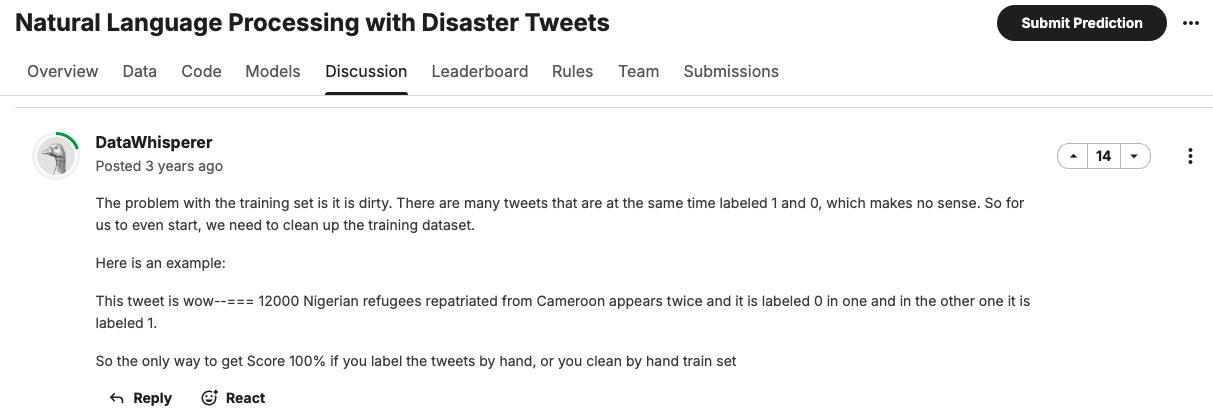![image.png]

No cóź, zamiast dumnie reprezentować Kogni na podium, zostało mi jedynie fajnie opisać sposoby podchodzenia do tego projektu z użyciem różnych technik. Jako ciekawostke dodam, że DistillBert poradził sobie odrobinkę lepiej niż BERT


In [ ]:
#podpinam colaba pod dysk google
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# wszystkie importy tutaj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn import feature_extraction, model_selection, preprocessing
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# trzy początkowe pliki
train_df = pd.read_csv("/content/drive/MyDrive/CogSCi/deep learning/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CogSCi/deep learning/test.csv")
sample_submission = pd.read_csv("/content/drive/MyDrive/CogSCi/deep learning/sample_submission.csv")

# Podejście z Klasyfikatorami

In [ ]:

#CountVectorizer wiadomo, do wektoryzacji tekstu, stop_words='english' usuwa słowa które nie mają znaczenia (a, the, itp)
count_vectorizer = feature_extraction.text.CountVectorizer(stop_words='english')

# klasycznie dzielimy dane na treningowe i testowe
train_vectors = count_vectorizer.fit_transform(train_df["text"])
test_vectors = count_vectorizer.transform(test_df["text"])

# Definiowanie klasyfikatorów
# Kolejność nie ma znaczenia, takie mieliśmy na zajęciach więc wziąłem
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Ridge Classifier": RidgeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB()
}

# Trenowanie i ocena klasyfikatorów
results = {}
for name, clf in classifiers.items():

    # Cross-validation czyli dzielenie danych na 5 części i trenowanie na 4 a testowanie na 1 przy uzyciu jednego z klasyfikatorow
    scores = model_selection.cross_val_score(clf, train_vectors, train_labels, cv=5, scoring="f1")

    # Nastepnie do slownika dodaje wyniki dla danego klasyfikatora
    results[name] = scores    
    print(f"{name} cross-validation scores: {scores}")

# Obliczanie średnich wyników aby wybrać najlepszy model
average_scores = {name: np.mean(scores) for name, scores in results.items()}

# ten key=average_scores.get to jest takie coś żeby zwrócić klucz dla którego wartość jest największa
best_model = max(average_scores, key=average_scores.get) 
print(f"Best model: {best_model} with average F1 score: {average_scores[best_model]}")


# Wykres, a co tam, bo mogę! 

plt.figure(figsize=(10, 5))
for name, scores in results.items():
    plt.plot(scores, label=name)
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.title('Comparison of Classifiers')
plt.legend()
plt.show()


# Trenowanie najlepszego modelu i zapisanie wyników do pliku bez indeksow tak jak chce kaggle
clf = classifiers[best_model]
clf.fit(train_vectors, train_labels)
predictions = clf.predict(test_vectors)

# No i submiszyn, nadpisujemy kolumne target predykcjami i zapisujemy do pliku csv bez indeksów
sample_submission['target'] = predictions
sample_submission.to_csv('submission_clf.csv', index=False)


# Podejście z Transformerem


In [ ]:
# tokenizer - zamienia tekst na tokeny, czyli na liczby które można przetworzyć potem w sieci neuronowej
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Matyczna klasa Dataset która pozwala na łatwe przetwarzanie danych w pytorch
# Klasa sama w sobie
class DisasterDataset(Dataset):

    # funkcja inicjalizująca
    def __init__(self, texts, targets=None, max_len=128):
        self.texts = texts # lista tekstów
        self.targets = targets # lista targetów czyli wyników
        self.tokenizer = tokenizer # teraz DistilBert
        self.max_len = max_len # maksymalna długość tekstu, dlaczego 128? jest taka konwencja ale jakiś inny powód też pewnie jest

    # funkcja zwracająca długość datasetu - przydatne do iteracji
    def __len__(self):
        return len(self.texts)

    # funkcja zwracająca element datasetu o danym indeksie
    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # encoding tekstu - zamiana na tokeny, encode_plus zwraca słownik z tokenami
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True, # dodaje tokeny [CLS] i [SEP] na początku i końcu tekstu po to żeby model wiedział gdzie zaczyna się tekst i gdzie kończy
            max_length=self.max_len, # maksymalna długość tekstu
            padding='max_length', # padding tekstu do maksymalnej długości
            truncation=True, # obcinanie tekstu do maksymalnej długości
            return_attention_mask=True, # zwracanie maski uwagi - mówi modelowi na które tokeny ma zwrócić uwagę
            return_tensors='pt' # zwracanie tensorów pytorch czyli tensorów które można przetwarzać w sieci neuronowej
        )
        # inpuds_ids to tokeny, attention_mask to maska uwagi, czyli taka maska która mówi modelowi na które tokeny ma zwrócić uwagę a na które nie
        item = {
            'input_ids': encoding['input_ids'].flatten(), # wszystkie spłaszczamy żeby były 1D
            'attention_mask': encoding['attention_mask'].flatten() 
        }
        # jeśli mamy targety to dodajemy je do słownika
        if self.targets is not None:
            item['targets'] = torch.tensor(self.targets[idx], dtype=torch.float)

        return item # zwracamy słownik z tokenami i targetami 

# Datasety oparte na DATASET, mają funkcje które pozwalają na łatwe przetwarzanie danych w pytorch 
train_dataset = DisasterDataset(train_df['text'].values, train_df['target'].values)
test_dataset = DisasterDataset(test_df['text'].values)

# Dataloadery pozwalają na łatwe przetwarzanie danych w pytorch, dzielą dane na batche, batch to porcja danych na której model jest trenowany
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # shuffle=False bo nie chcemy mieszać danych testowych

# załadowanie modelu
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)
# uruchomienie modelu na cuda jeśli jest 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device) # przeniesienie modelu na cuda/cpu 

# Adam optimalizuje i spadam, AdamW to Adam z weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
# Binary Cross Entropy with Logits Loss to funkcja kosztu która jest niby najlepsza do problemów binarnych
criterion = torch.nn.BCEWithLogitsLoss()

# Trenowanie modelu
model.train()
for epoch in range(3): # 3 epoki, więcej mi wypala dziure w komputerze 
    for batch in tqdm(train_loader): # tqdm aby widac bylo pasek postępu

        # zerowanie gradientów - po to żeby nie dodawać gradientów z poprzednich iteracji
        optimizer.zero_grad()

        # przeniesienie danych na cuda/cpu
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['targets'].to(device)
        
        # przetworzenie danych przez model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits.squeeze(), targets)

        # propagacja wsteczna - obliczanie gradientów
        loss.backward()

        # aktualizacja wag modelu na podstawie gradientów
        optimizer.step()

# Ewaluacja modelu
model.eval()
predictions = []

# Torch.no_grad() oznacza że nie obliczamy gradientów, nie potrzebujemy ich bo teraz nie trenujemy modelu
with torch.no_grad():

    # To co wczesniej tylko teraz na danych testowych
    for batch in tqdm(test_loader):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Dodajemy predykcje do listy, sigmoid bo mamy jedną klasę i chcemy żeby wynik był między 0 a 1, logits.squeeze() bo chcemy się pozbyć jednego wymiaru
        # > 0.5 bo chcemy żeby wynik był 0 albo 1, .cpu() bo chcemy żeby wynik był na cpu a nie na gpu, .numpy() bo chcemy żeby wynik był w numpy arrayu 
        predictions.extend((torch.sigmoid(outputs.logits.squeeze()) > 0.5).cpu().numpy())

# Zapisujemy model i tokenizer żeby potem go wczytać bez uczenia
model.save_pretrained("model2_do_drugiego")
tokenizer.save_pretrained("model2_do_drugiego")

# No i submiszyn znowu
sample_submission['target'] = predictions
sample_submission.to_csv('submission_bert.csv', index=False)


NameError: name 'DistilBertTokenizer' is not defined